In [1]:
# General dependencies
import os, shutil
from os.path import join
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy

In [2]:
# LCBD dependencies
# add relative path to our toolbox
import sys
sys.path.append('../../..') # path to preprocessing from here

from preprocessing.scripts import argParser
from preprocessing.src import Plots
from preprocessing.src import Statistics
from preprocessing.src import TimeSeries
from preprocessing.Stimuli.FreeViewing.ATV import TrialReader

In [3]:
# Some configuration variables
dataDir = "/data/perlman/moochie/user_data/SchneiderClayton/studyData/ATV_LCBD_copy_120821/data"
# episode = 1 # which episode number (1-3) we are dealing with
TR = 0.8 # this is because we'll want to have it sampled at the TR for later (s)
min_episode_samples = 900 # some recordings are shorter than others, and we don't want to include them...
ex_subs = ['102'] # any subjects to not include in the dataset
participant_num_len = 3 # default length of participant numbers

In [4]:
# build a list of all the applicable ATV data files
fnames = [join(dataDir, fname) for fname in os.listdir(dataDir)\
    if os.path.basename(fname)[:participant_num_len] not in ex_subs]

dataset = []
print("Loading ATV files as TimeSeries objects:")
print("==========")
for fpath in tqdm(fnames):
    try:
        # for each filepath in the list, run an ATV.TrialReader builder
        # add each src.TimeSeries object generated from the TrialReader to
        # the dataset list
        for ts in TrialReader(fpath).ratingsSeries:
            dataset.append(ts)
    except:
        print("Failure to read:", os.path.basename(fpath))
        pass

Loading ATV files as TimeSeries objects:


100%|██████████| 17/17 [00:26<00:00,  1.56s/it]


In [5]:
print("Preprocessing TimeSeries:")
print("==========")
for ts in tqdm(dataset):
    # correct NaN values
    ts.fix_nan()
    # accommodate for skippy framerates
    ts.lag_correct()
    # sample to TR
    ts.resample(sample_rate=TR)
    # chunking
    ts.signal = ts.round_res()

Preprocessing TimeSeries:


100%|██████████| 47/47 [00:07<00:00,  6.05it/s]


Inspecting Lengths of Ratings in Each Episode:


100%|██████████| 3/3 [00:00<00:00, 90.00it/s]


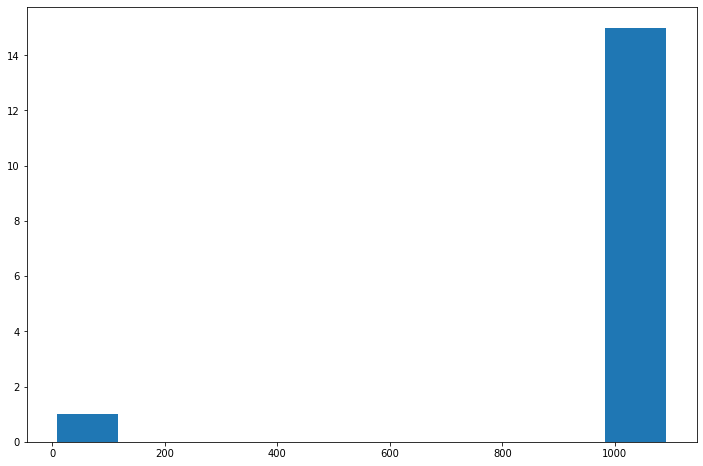

In [6]:
print("Inspecting Lengths of Ratings in Each Episode:")
print("==========")
episodes = []

for episode in tqdm(list(set([ts.meta['episode'] for ts in dataset]))):
    episodes.append(episode)
    plt.hist([len(ts.signal) for ts in dataset\
        if ts.meta['episode']==episode])

Inspecting Lengths of Ratings in Each Episode After Dropping:


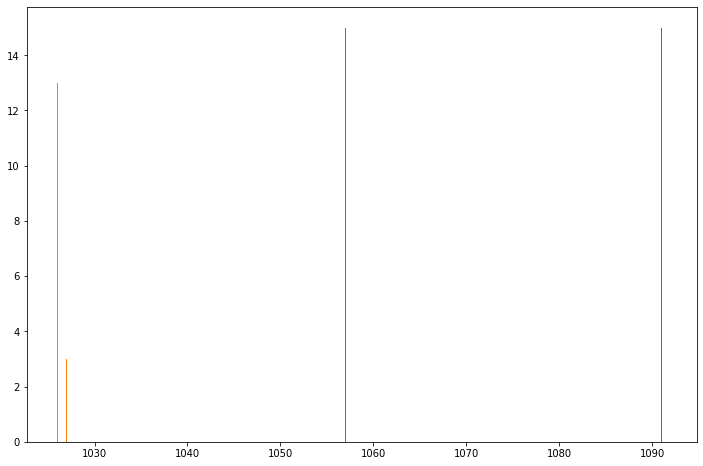

In [7]:
print("Inspecting Lengths of Ratings in Each Episode After Dropping:")
print("==========")

dataset = [ts for ts in dataset if len(ts.signal) > min_episode_samples]

for episode in episodes:
    plt.hist([len(ts.signal) for ts in dataset\
        if ts.meta['episode']==episode])

In [8]:
print("Matching Lengths and Discretizing By Episode with Averages of Each:")
print("==========")

episodes = []
d_dataset = {}
d_avgs = {}
# truncate each batch of runs with the same episode to the length of the
# shortest trial in the batch
for episode in tqdm(list(set([ts.meta['episode'] for ts in dataset]))):
    episodes.append(episode)
    ep_min = min([len(ts.signal) for ts in dataset\
        if ts.meta['episode']==episode and len(ts.signal) > min_episode_samples])
    for ts in [ts for ts in dataset if ts.meta['episode']==episode]:
        ts.signal = ts.signal[:ep_min]
        ts.time = ts.time[:ep_min]
        
    # discretize the dataset to a dict with entry for each episode
    d_dataset[episode] = [ts for ts in dataset if ts.meta['episode'] == episode]
    # make averages (discretized) of each episode's runs (same struc as d_dataset)
    d_avgs[episode] = TimeSeries.TimeSeries(
        signal=np.average(np.array([ts.signal for ts in d_dataset[episode]]), axis=0),
        time=ts.time,
        meta={
            'participant': 'AVG',
            'episode': episode})

Matching Lengths and Discretizing By Episode with Averages of Each:


100%|██████████| 3/3 [00:00<00:00, 3639.84it/s]


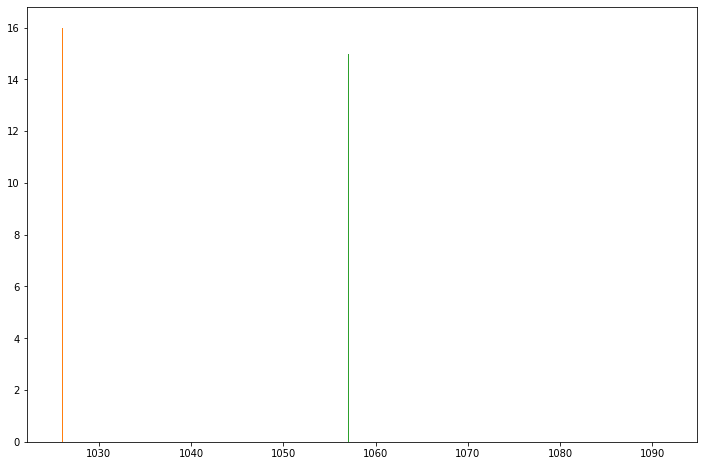

In [9]:
for episode in episodes:
    plt.hist([len(ts.signal) for ts in d_dataset[episode]])

In [10]:
# just view the structure of this object
print(d_dataset)
print(d_avgs)

{0: [<preprocessing.src.TimeSeries.TimeSeries object at 0x7f998e897790>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f998e819250>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f998e897950>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f998e819cd0>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f998e897c90>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f998e883a50>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f998e897c50>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f998e883090>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f998e897cd0>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f998e832510>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f998e819b10>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f998e8971d0>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f998e819150>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f998e897b50>, <preprocessing.src.TimeSeries.TimeSeries ob

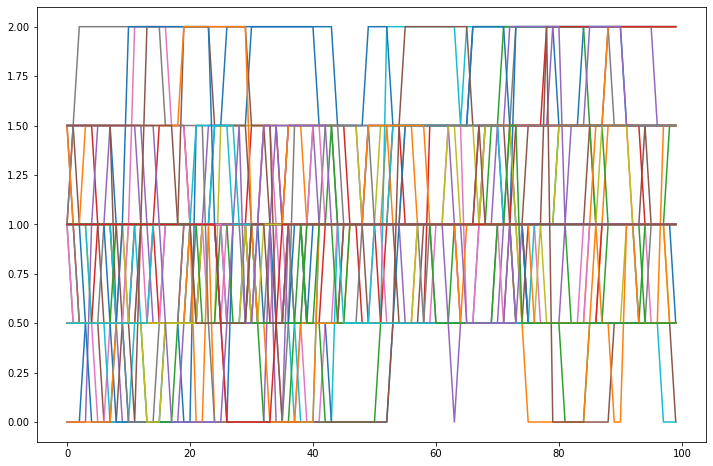

In [11]:
for episode in episodes:
    for ts in d_dataset[episode]:
        plt.plot(ts.signal[200:300])

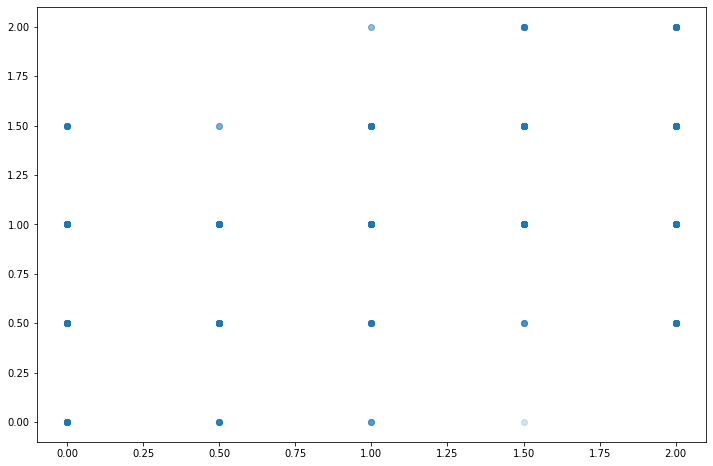

In [12]:
plt.scatter(
    d_dataset[0][0].signal,
    d_dataset[0][1].signal,
    alpha=0.2)

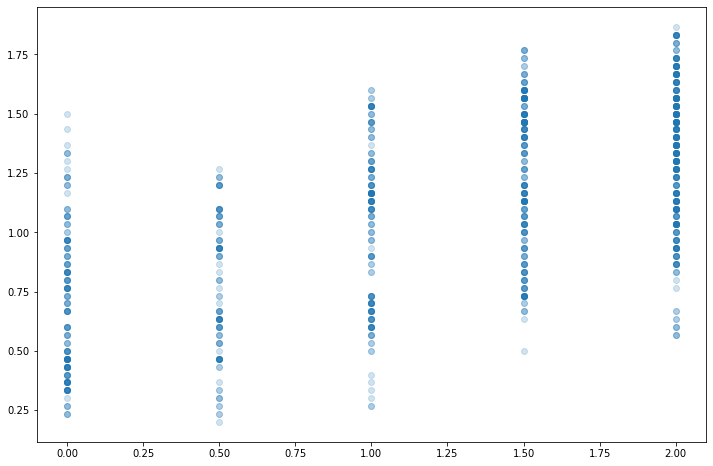

In [13]:
plt.scatter(
    d_dataset[0][0].signal,
    d_avgs[0].signal,
    alpha=0.2)

In [14]:
d_dataset[0][0].__dict__

{'signal': array([1. , 1. , 1. , ..., 1.5, 1.5, 1.5]),
 'time': array([0.00000000e+00, 1.25137615e+00, 2.50275229e+00, ...,
        1.36149725e+03, 1.36274862e+03, 1.36400000e+03]),
 'sampleRate': 0.8,
 'meta': {'participant': '111', 'episode': 0, 'viewingOrder': 'BAC'},
 'unit': 's'}

In [15]:
Statistics.ping_icc([
    d_dataset[0][0],
    d_dataset[0][1]])

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.382420,2.238446,1090,1091,1.127524e-39,"[0.33, 0.43]"
1,ICC2,Single random raters,0.400904,2.486933,1090,1090,8.842774e-50,"[0.31, 0.48]"
2,ICC3,Single fixed raters,0.426430,2.486933,1090,1090,8.842774e-50,"[0.38, 0.47]"
3,ICC1k,Average raters absolute,0.553262,2.238446,1090,1091,1.127524e-39,"[0.5, 0.6]"
4,ICC2k,Average random raters,0.572350,2.486933,1090,1090,8.842774e-50,"[0.48, 0.65]"
5,ICC3k,Average fixed raters,0.597898,2.486933,1090,1090,8.842774e-50,"[0.55, 0.64]"


In [16]:
# initialize empty array for icc values (one per timepoint)
icc_dfs = {}
icc_vals = {}

for episode in episodes[:1]:
    
    # labels are all participants for episode + 'avg'
    xticklabels = list(set([ts.meta['participant'] for ts in d_dataset[episode]]))
    xticklabels.append('avg')
    yticklabels = deepcopy(xticklabels)
    
    df = pd.DataFrame(
        columns=xticklabels,
        index=yticklabels)
    
    
    for j, row in enumerate(df.index):
        for i, col in enumerate(df.columns):
        
            # case that we are in upper-right triangle of matrix
            if i > j:
                # grab ts1
                if col == 'avg':
                    ts1 = d_avgs[episode]
                else:
                    # the index of the dataset where the participant is col
                    ts1 = d_dataset[episode][[ts.meta['participant'] for ts in d_dataset[episode]].index(col)]
                    
                # grab ts2
                if row == 'avg':
                    ts2 = d_avgs[episode]
                else:
                    # the index of the dataset where the participant is row
                    ts2 = d_dataset[episode][[ts.meta['participant'] for ts in d_dataset[episode]].index(row)]

                try:
                    # compute ICC between ts1 and ts2
                    icc = Statistics.ping_icc([ts1, ts2])

                    df.iat[j, i] = icc.iat[0,2]
                    
                    # if significance
                    # if icc.iat[0, 6] < 0.05:
                        # df.iat[j, i] = df.iat[j, i]+"*"
                    
                except:
                    df.iat[rowIndex, colIndex] = 0
                    print("Err @ row ", row, "col", col)
                    
            # case we are on diagonal
            elif i == j:
                df.iat[j, i] = 1
                
            # case that we are in bottom-left triangle of matrix
            else:
                df.iat[j, i] = df.iat[i, j]
            
    icc_dfs[episode] = df
    
    # do icc for whole set of them (not including average)
    icc = Statistics.ping_icc(d_dataset[episode])
    icc_vals[episode] = icc.iat[0,2].round(2)

In [18]:
icc_dfs[0]

,109,110,112,103,114,111,105,107,115,106,108,101,113,100,104,avg
109,1,0.309733,0.387154,0.381244,0.360361,0.263085,0.374006,0.311946,0.36752,0.317337,0.179001,0.224779,0.36616,0.357693,0.512157,0.543234
110,0.309733,1,0.347302,0.405349,0.49173,0.262735,0.354689,0.211203,0.369636,0.409325,0.411403,0.386721,0.560752,0.433302,0.472002,0.600563
112,0.387154,0.347302,1,0.461893,0.668033,0.449957,0.650606,0.444761,0.454948,0.523309,0.45695,0.490383,0.646869,0.564694,0.624224,0.779745
103,0.381244,0.405349,0.461893,1,0.469493,0.358886,0.502237,0.335792,0.325166,0.369642,0.271764,0.275376,0.366357,0.327755,0.554099,0.591103
114,0.360361,0.49173,0.668033,0.469493,1,0.385871,0.473333,0.333375,0.422334,0.522381,0.547494,0.539755,0.615637,0.598565,0.627517,0.750237
111,0.263085,0.262735,0.449957,0.358886,0.385871,1,0.38242,0.262353,0.276122,0.35835,0.272777,0.271565,0.388048,0.45547,0.443412,0.500888
105,0.374006,0.354689,0.650606,0.502237,0.473333,0.38242,1,0.533944,0.497036,0.416872,0.298867,0.392386,0.534072,0.490168,0.585219,0.729664
107,0.311946,0.211203,0.444761,0.335792,0.333375,0.262353,0.533944,1,0.400323,0.336065,0.210586,0.3012,0.360524,0.237621,0.390033,0.586784
115,0.36752,0.369636,0.454948,0.325166,0.422334,0.276122,0.497036,0.400323,1,0.342648,0.20809,0.233255,0.465144,0.348015,0.432886,0.598812
106,0.317337,0.409325,0.523309,0.369642,0.522381,0.35835,0.416872,0.336065,0.342648,1,0.534351,0.526977,0.67263,0.38173,0.615186,0.621576


In [21]:
cmatrix = np.array(icc_dfs[0]).astype(float)

In [22]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

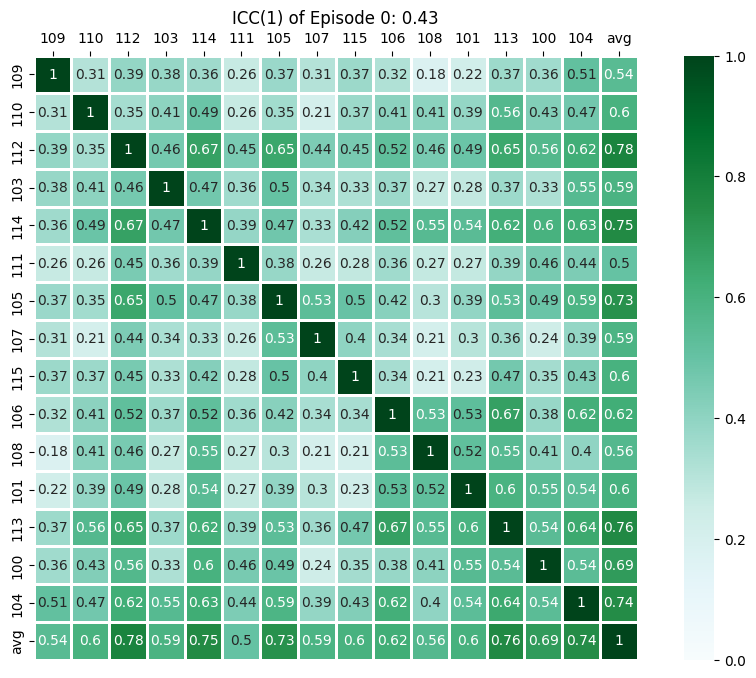

In [24]:
ax = sns.heatmap(
    cmatrix,
    annot=True,
    xticklabels=[str(col) for col in icc_dfs[0].columns],
    yticklabels=[str(ind) for ind in icc_dfs[0].index],
#     cmap=sns.diverging_palette(20, 220, n=200),
    cmap="BuGn",
    linewidths=1,
    square=True,
    vmin=0,
    vmax=1)

ax.set_title("ICC(1) of Episode 0: {}".format(icc_vals[0]))
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')

# ax.set_xticklabels(
#     [str(col) for col in iccs[0].columns],
#     rotation=45,
#     horizontalalignment='right')